# Predicting Usage of a Video Game Research Server - Final Report

`project-004-12`
- Neil Zhu
- Peti Setabandhu (41047416)
- Tuna Sayin
- Tiangxiang Song (54550017)

Link to GitHub repo: https://github.com/peteseta/dsci-100-project

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)
library(GGally)

options(repr.matrix.max.rows = 6)

## Introduction

PLAIcraft is a research server for the popular game Minecraft, designed to collect behavioral data from players for academic studies. The server's success depends on recruiting players who will contribute substantial playtime and generate rich datasets, as this research will require large datasets of player behavior to draw meaningful conclusions.

Understanding which types of players are most likely to engage deeply with the server is crucial for efficient recruitment - by analyzing demographic information and self-reported experience levels, we can identify characteristics associated with high engagement.

Our **research question** is thus can player demographic characteristics (age, gender, experience level, newsletter subscription status) predict the total hours played on the PLAIcraft server?

This falls under the broad question
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

We first take an initial look at the data:

In [3]:
players <- read_csv("https://raw.githubusercontent.com/peteseta/dsci-100-project/refs/heads/main/data/players.csv")

head(players)
summary(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

### Dataset description

We analyzed the `players.csv` dataset, which contains information about 196 registered PLAIcraft players. The dataset includes 196 observations with the following 7 variables:

- `experience` (categorical): Player's self-reported experience level - "Beginner", "Amateur", "Regular", "Pro", or "Veteran"
- `subscribe` (logical): Whether the player subscribed to the server newsletter (TRUE/FALSE)
- `hashedEmail` (character): Anonymized identifier for each player
- `played_hours` (numeric): Total playtime on the server in hours
- `name` (character): Player's username
- `gender` (categorical): Player's self-reported gender
- `Age` (numeric): Player's age in years

We initially noted some issues with the data, including missing values in the `Age` variable and a large number of players with zero recorded playtime (indicating they registered but never played).

## Methods and results:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
    - loads data
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis
note: all figures should have a figure number and a legend

### Data loading, wrangling, and exploratory analysis
We begin by wrangling the data such that the column names are consistent, experience and gender are properly treated as factors, and that we remove observations with missing values.

In [4]:
# wrangle data
# clean names, convert to factors, remove missing values
players_clean <- players |>
    clean_names() |>
    mutate(
        experience = factor(experience,
                            levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")),
        gender = factor(gender)
    ) |>
    drop_na()

players_clean

# summary of cleaned dataset
cat("original observations:", nrow(players), "\n")
cat("after removing NA values:", nrow(players_clean), "\n")

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


original observations: 196 
after removing NA values: 194 


Two rows containing missing data were removed. Then, we perform an exploratory data analysis, calculating summary statistics for each numerical column and counts for each categorical column.

In [5]:
# EDA
summary_stats <- players_clean |>
    summarize(
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        median_played_hours = median(played_hours, na.rm = TRUE),
        sd_played_hours = sd(played_hours, na.rm = TRUE),
        mean_age = mean(age, na.rm = TRUE),
        median_age = median(age, na.rm = TRUE),
        sd_age = sd(age, na.rm = TRUE)
    )

summary_stats

experience <- players_clean |>
    count(experience)

gender <- players_clean |>
    count(gender)

subscribe <- players_clean |>
    count(subscribe)

experience
gender
subscribe

mean_played_hours,median_played_hours,sd_played_hours,mean_age,median_age,sd_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.904639,0.1,28.49793,21.13918,19,7.389687


experience,n
<fct>,<int>
Beginner,35
Amateur,63
Regular,35
Pro,13
Veteran,48


gender,n
<fct>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Prefer not to say,11
Two-Spirited,5


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,142


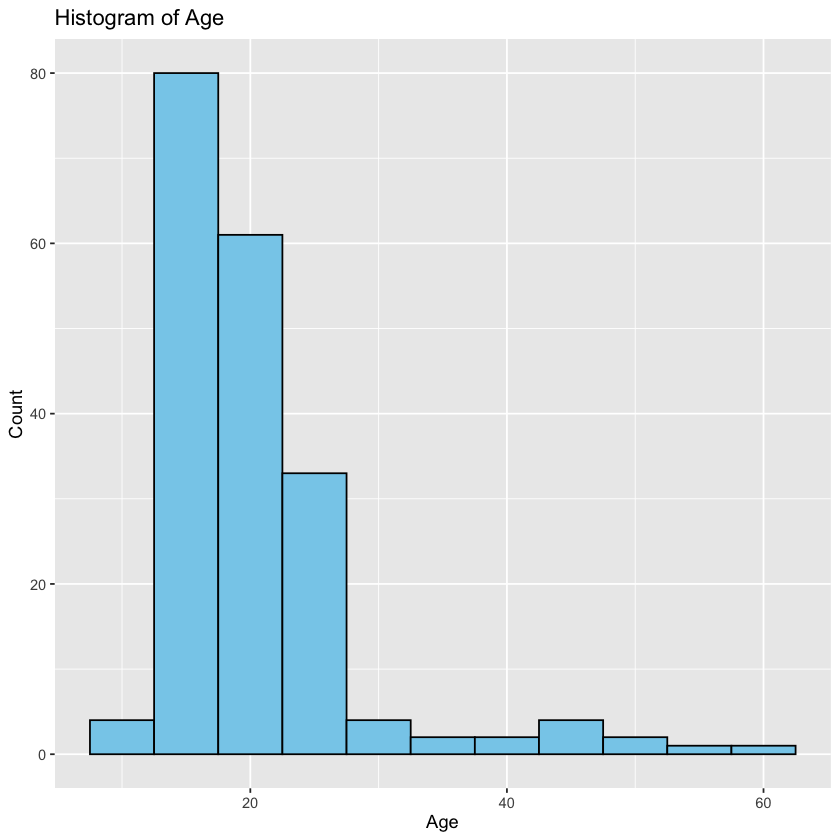

In [6]:
# visualization 1 - age distribution
ggplot(players_clean, aes(x = age)) +
  geom_histogram(binwidth = 5, color = "black", fill = "skyblue") +
  labs(title = "Histogram of Age", x = "Age", y = "Count")

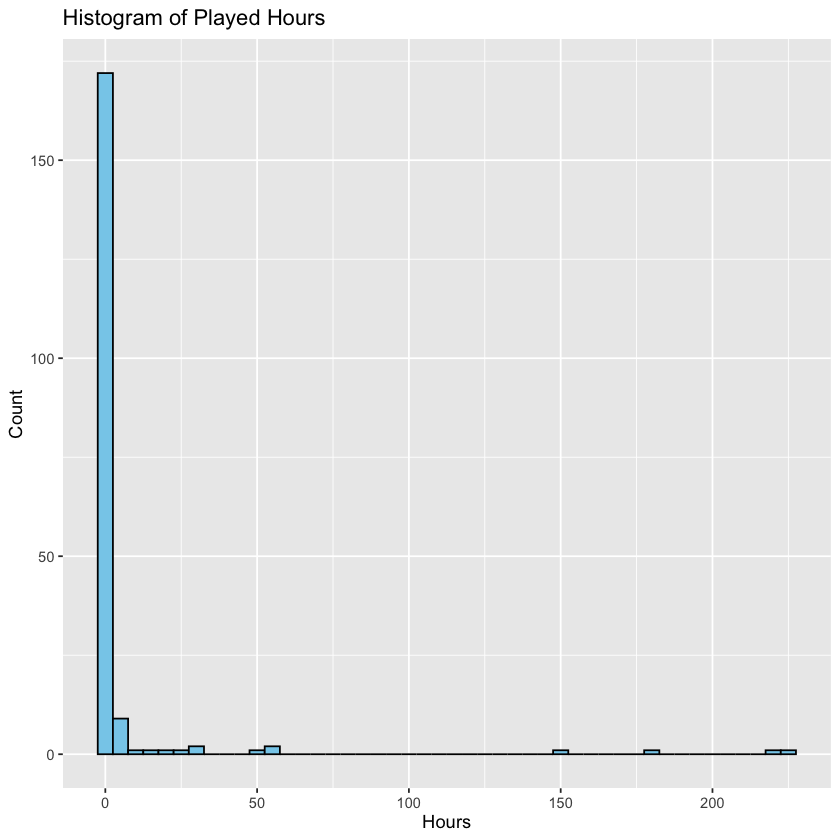

In [7]:
# visualization 2 - played hours distribution
ggplot(players_clean, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, color = "black", fill = "skyblue") +
  labs(title = "Histogram of Played Hours", x = "Hours", y = "Count")

Warning message in geom_point(color = "steelblue", calpha = 0.6):
“Ignoring unknown parameters: `calpha`”
`geom_smooth()` using formula = 'y ~ x'


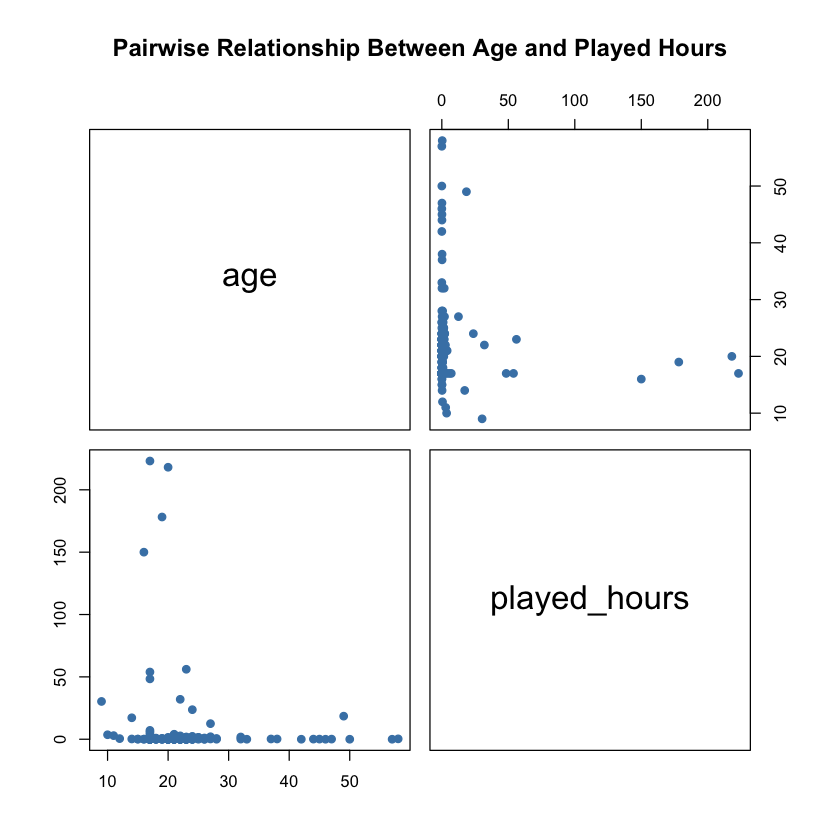

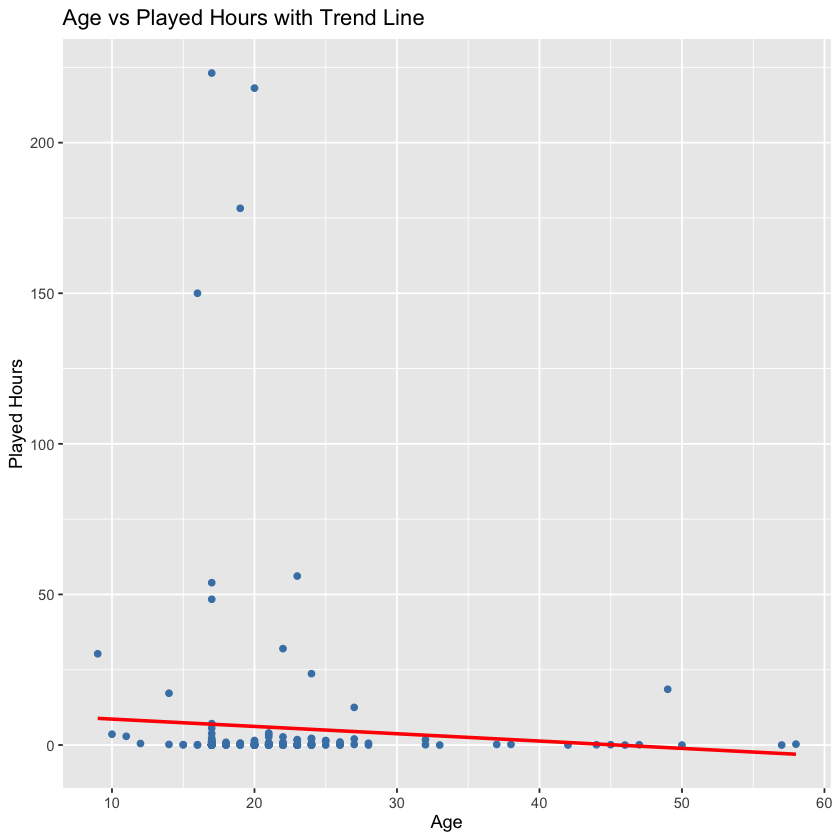

In [8]:
# visualization 3 - pairwise relationships
pairs(
  players_clean[, c("age", "played_hours")],
  main = "Pairwise Relationship Between Age and Played Hours",
  pch = 19,
  col = "steelblue"
)

ggplot(players_clean, aes(x = age, y = played_hours)) +
  geom_point(color = "steelblue", calpha = 0.6) +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  labs(
    title = "Age vs Played Hours with Trend Line",
    x = "Age",
    y = "Played Hours"
  )

### Model training

In [15]:
# split data
set.seed(123)
data_split <- initial_split(players_clean, prop = 0.8, strata = played_hours)
train_data <- training(data_split)
test_data  <- testing(data_split)

In [17]:
# k-nn recipe and preprocessing
knn_recipe <- recipe(played_hours ~ age + gender + experience + subscribe,
                     data = train_data) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())


#### Cross-validation for parameter selection

In [20]:
# k-nn model specification
knn_spec <- nearest_neighbor(
    neighbors = tune(),
    weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("regression")

In [21]:
# k-nn workflow for cross validation
knn_wflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe)

In [28]:
# tune model
set.seed(123)
folds <- vfold_cv(train_data, v = 5, strata = played_hours)

tune_results <- tune_grid(
  knn_wflow,
  resamples = folds,
  grid = tibble(neighbors = seq(1, 50, by = 1))
)

tune_metrics <- tune_results |>
    collect_metrics()

tune_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,32.52330588,5,5.72443362,pre0_mod01_post0
1,rsq,standard,0.01422221,5,0.01230055,pre0_mod01_post0
2,rmse,standard,28.33506178,5,5.61020452,pre0_mod02_post0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,rsq,standard,0.01397484,5,0.006794079,pre0_mod49_post0
50,rmse,standard,25.91434158,5,6.513364840,pre0_mod50_post0
50,rsq,standard,0.01048718,5,0.006487490,pre0_mod50_post0


neighbors,.config
<dbl>,<chr>
20,pre0_mod20_post0


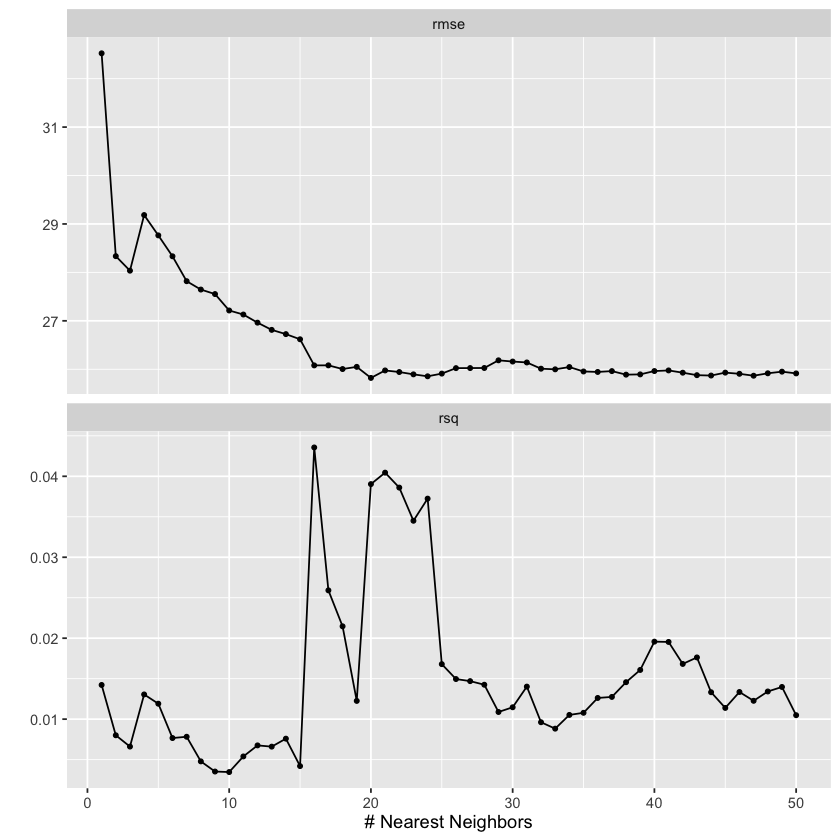

In [29]:
# visualize optimal k value
autoplot(tune_results)

best_k <- select_best(tune_results, metric = "rmse")
best_k

#### Modeling with the optimal k-value

In [30]:
# k-nn model specification and workflow with optimal k value
final_knn_model <- finalize_workflow(knn_wflow, best_k)

final_fit <- final_knn_model |>
    fit(data = train_data)

### Model evaluation

In [31]:
# metrics on test set
test_results <- final_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = played_hours, estimate = .pred)

test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,27.70115057
rsq,standard,0.01699871
mae,standard,10.16687500


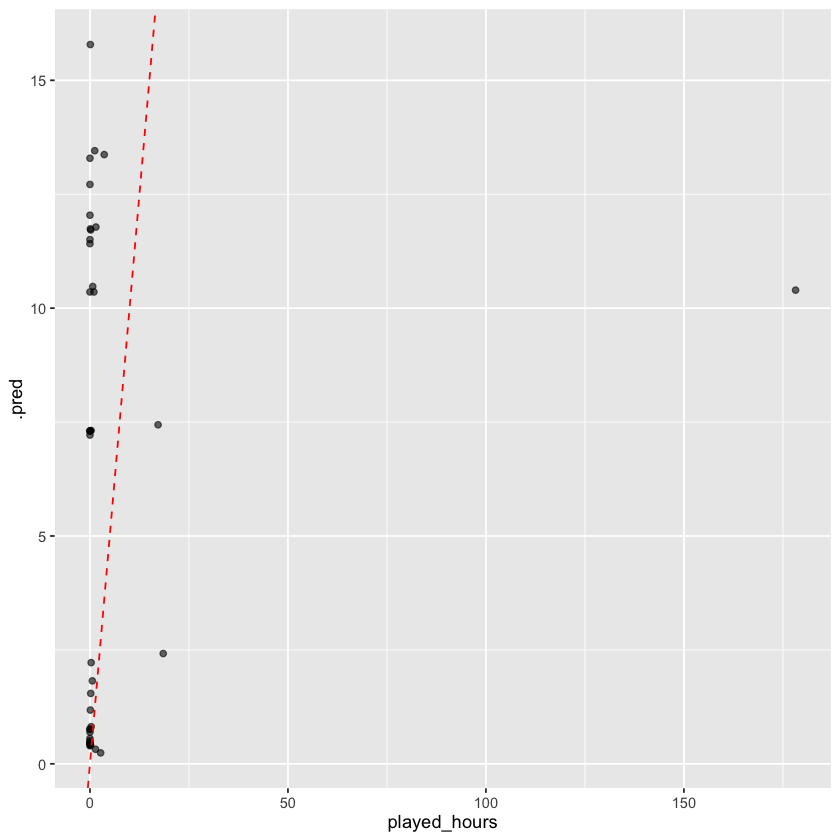

In [32]:
# visualization of predicted vs actual
final_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  ggplot(aes(x = played_hours, y = .pred)) +
  geom_point(alpha = 0.6) +
  geom_abline(linetype = "dashed", color = "red")

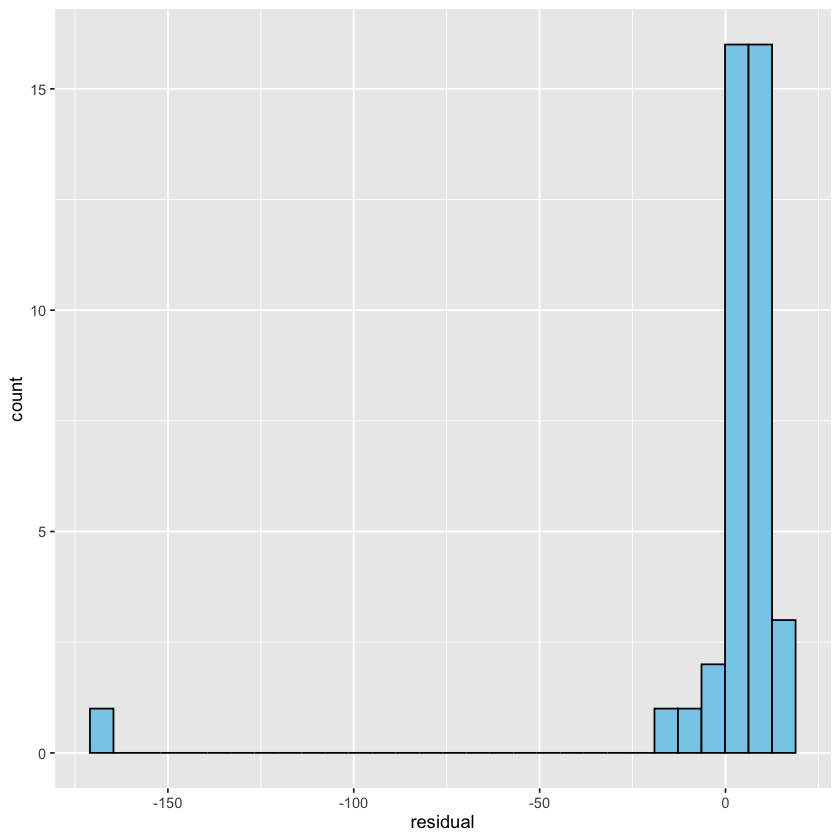

In [33]:
# visualization of residuals
final_fit |>
  predict(test_data) |>
  mutate(residual = .pred - test_data$played_hours) |>
  ggplot(aes(x = residual)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black")

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## References
You may include references if necessary, as long as they all have a consistent citation style.

In [67]:
# count words in all markdown cells of this notebook
suppressPackageStartupMessages({
  ok_jsonlite <- require(jsonlite, quietly = TRUE)
  ok_stringr  <- require(stringr, quietly = TRUE)
})

# simple helper for NULL-coalescing (define before use)
`%||%` <- function(a, b) if (is.null(a)) b else a

# resolve path to this notebook
path <- "final-project.ipynb"
if (!file.exists(path)) {
  path <- "final-project.ipynb"
}
if (!file.exists(path)) stop("wrong path")

# read the notebook JSON
nb <- jsonlite::read_json(path, simplifyVector = FALSE)
cells <- nb$cells

# identify markdown cells and collect their text
md_idx <- which(vapply(cells, function(x) identical(x$cell_type, "markdown"), logical(1)))
md_texts <- lapply(cells[md_idx], function(x) paste0(x$source %||% "", collapse = "\n"))

# word counting function with light markdown cleanup
count_words <- function(text) {
  text <- stringr::str_replace_all(text, "\\r", "\n")
  # remove comments: HTML comments and common Markdown comment syntaxes
  text <- stringr::str_remove_all(text, stringr::regex("<!--.*?-->", dotall = TRUE))
  text <- stringr::str_remove_all(text, "(?m)^\\[//\\]:\\s*#\\s*\\(.*?\\)\\s*$")
  text <- stringr::str_remove_all(text, "(?m)^\\[comment\\]:\\s*<>\\s*\\(.*?\\)\\s*$")
  # convert links/images to just their alt/text
  text <- stringr::str_replace_all(text, "!\\[([^\\]]*)\\]\\([^\\)]+\\)", "\\1")
  text <- stringr::str_replace_all(text, "\\[([^\\]]+)\\]\\([^\\)]+\\)", "\\1")
  # remove HTML tags and code ticks
  text <- stringr::str_replace_all(text, "<[^>]+>", " ")
  text <- stringr::str_replace_all(text, "`+", " ")
  # remove heading/bullet markers at line starts
  text <- stringr::str_replace_all(text, "(?m)^[#>\\-\\*\\+]+\\s*", " ")
  # extract word-like tokens (letters, numbers, hyphen, apostrophe) using unicode classes
  toks <- stringr::str_extract_all(text, "\\b[\\p{L}][\\p{L}\\p{N}'-]*\\b", simplify = FALSE)[[1]]
  length(toks)
}

counts <- vapply(md_texts, count_words, integer(1))

cat(sprintf("\nTotal words across markdown cells: %d\n", sum(counts)))

word_counts <- tibble::tibble(cell_number = md_idx, word_count = counts)
word_counts



Total words across markdown cells: 514


cell_number,word_count
<int>,<int>
1,28
3,1
4,147
⋮,⋮
34,0
35,17
36,0
